In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12
df = pd.read_csv('data_clean_NoNaN_body.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)


In [6]:
df['Price'] = df['Price'].str.replace('[^0-9]', '', regex=True)
df['Price'] = df['Price'].replace('', np.nan)
df = df.dropna(subset=['Price'])
df['Price'] = pd.to_numeric(df['Price'])
df

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
0,Fiat Doblo Cargo 1.9 JTD Grijs Kenteken Bestel...,I Boumans,18500,Gennep,2005,199.313 km,Diesel,Handgeschakeld,Limburg
1,Ford Ranger Open-laadbak 2.2TDCI 160PK Dubbele...,DUTCH Vans,22600,Barneveld,2017,107.195 km,Diesel,Handgeschakeld,Gelderland
2,Aixam Roadline -2008- incl. 3 mnd garantie + o...,Garage Kaal & Buunk,6950,Beek,2008,47.108 km,Diesel,Automaat,Limburg
3,Mercedes-Benz Sprinter 314CDI 143pk L2H2 Koelw...,Van der Wal Vans,32900,Langerak,2018,148.939 km,Diesel,Handgeschakeld,Drenthe
4,Opel Corsa 1.2 Turbo Start/stop 100pk Aut 2021...,Adam,18500,Amsterdam,2021,26.200 km,Benzine,Automaat,Noord-Holland
...,...,...,...,...,...,...,...,...,...
8891,Renault Trafic L2 H1 2021 €344 per maand,Action Lease,24700,Heel Nederland,2021,67.051 km,Diesel,Handgeschakeld,In every province
8892,Renault Master L3 H1 2022 €635 per maand,Action Lease,41800,Heel Nederland,2022,60 km,Diesel,Handgeschakeld,In every province
8893,Iveco Daily L2 H2 2022 €648 per maand,Action Lease,42600,Heel Nederland,2022,30 km,Diesel,Automaat,In every province
8894,Volkswagen Crafter L2 H2 2017 €247 per maand,Action Lease,17600,Heel Nederland,2017,198.504 km,Diesel,Handgeschakeld,In every province


As seen below there are some very large values as a car sale but the mean is much smaller than this therefore we will look at the percentage of total sales compared to how many listings are above 100k.

In [7]:
pd.options.display.float_format = '{:.2f}'.format
df["Price"].describe()

count      8788.00
mean      18867.52
std       49389.25
min           0.00
25%        1686.75
50%       14700.00
75%       24900.00
max     3399999.00
Name: Price, dtype: float64

As we can see below cars with a listing price more than 150k only make up 0.3% of all listings and with some major outliers such as a car of 5 million euro's this is one of a kind and therefore will be viewed as outlier.

In [8]:
count = 0
for price in df["Price"]:
    if price > 150000:
        count += 1
total = len(df["Price"])
percentage = count / total *100
number = len(df["Price"]) * (percentage /100)
percentage, number

(0.28447883477469277, 25.0)

In [9]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


df = remove_outliers(df, 'Price', lower=500, upper=150000)

In [10]:
df["Price"].describe()


count     7036.00
mean     21774.34
std      17860.79
min        505.00
25%       9999.00
50%      17950.00
75%      28650.00
max     149999.00
Name: Price, dtype: float64

Let's start by looking at the price distribuion of all car listings.

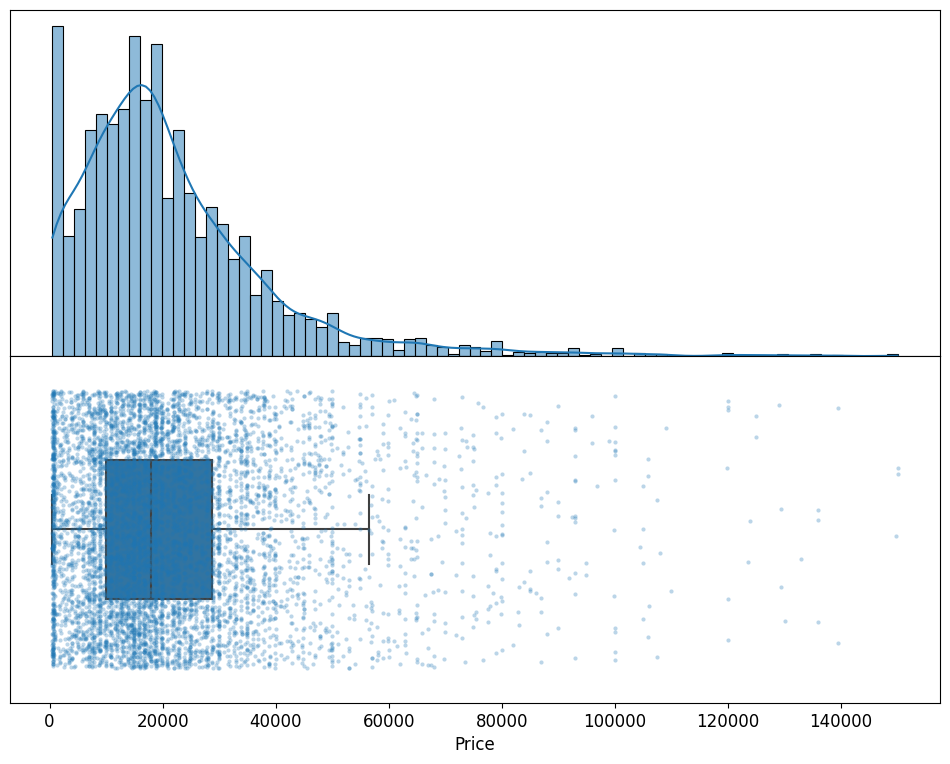

In [11]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

In [12]:
df.loc[df.Price<1000]

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
148,Porsche Cayenne 4.8 GTS | Sport chrono | Leder...,ROS finance,626,Veenendaal,2012,162.865 km,Benzine,Automaat,Utrecht
149,Audi Q5 55 TFSI e 367PK 20INCH 3X S-LINE LUCHT...,ROS finance,879,Veenendaal,2020,32.765 km,Overige brandstoffen,Automaat,Utrecht
159,Mercedes-Benz A-Klasse 200 *AMG EDITION 1* Pan...,ROS finance,621,Veenendaal,2018,39.945 km,Benzine,Automaat,Utrecht
177,Nissan Almera 2.2 Di Luxury airco 4drs 2000 blauw,HSV Auto's,999,Vaassen,2000,250.000 km,Diesel,Handgeschakeld,Gelderland
292,Peugeot 206 1.4 X-line 3D 2001 Blauw,Hofman,900,Rotterdam,2001,149.000 km,Benzine,Handgeschakeld,Zuid-Holland
...,...,...,...,...,...,...,...,...,...
6892,Mercedes-Benz Sprinter | 513 CDI bakwagen met ...,Regeljelease.nl,574,Heel Nederland,2015,191.308 km,Diesel,Handgeschakeld,In every province
6939,Mercedes-Benz Sprinter | 319,Regeljelease.nl,763,Heel Nederland,2021,76.857 km,Diesel,Automaat,In every province
6950,SsangYong Rexton | SAPPHIRE,Regeljelease.nl,797,Heel Nederland,2022,17 km,Diesel,Automaat,In every province
6963,Mercedes-Benz Sprinter | 319 3.0 CDI V6 Aut. L2H2,Regeljelease.nl,796,Heel Nederland,2021,88.534 km,Diesel,Automaat,In every province


We see there are many cars under the price of 1000. Even though we expect there to be some, it feels like there are too many.
Looking at the table above shows that many of these cars are leases. This can be seen by the fact that the seller name and title contain the word lease, and also by the fact that cars under 1000 should mostly be low value old cars, not a 2012 4.8 Porsche Cayenne :).

We can try to remove lease options by first of all looking at which titles and sellers contain the words lease, finance, etc.
We could also make an argument for a correlation between Year and price, and decide that cars built after a certain year should not be less than 1000 euros.


In [14]:
df = df[~df.Title.str.contains('lease|finance', case=False)]
df = df[~df.Seller.str.contains('lease|finance', case=False)]
df

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
0,Fiat Doblo Cargo 1.9 JTD Grijs Kenteken Bestel...,I Boumans,18500,Gennep,2005,199.313 km,Diesel,Handgeschakeld,Limburg
1,Ford Ranger Open-laadbak 2.2TDCI 160PK Dubbele...,DUTCH Vans,22600,Barneveld,2017,107.195 km,Diesel,Handgeschakeld,Gelderland
2,Aixam Roadline -2008- incl. 3 mnd garantie + o...,Garage Kaal & Buunk,6950,Beek,2008,47.108 km,Diesel,Automaat,Limburg
3,Mercedes-Benz Sprinter 314CDI 143pk L2H2 Koelw...,Van der Wal Vans,32900,Langerak,2018,148.939 km,Diesel,Handgeschakeld,Drenthe
4,Opel Corsa 1.2 Turbo Start/stop 100pk Aut 2021...,Adam,18500,Amsterdam,2021,26.200 km,Benzine,Automaat,Noord-Holland
...,...,...,...,...,...,...,...,...,...
7011,Ford Transit H1 L3 Diesel 2016 Wit,Dutchvans.com,16700,Barneveld,2016,95.864 km,Diesel,Handgeschakeld,Gelderland
7012,Volkswagen Crafter H1 L5 Diesel 2012 Groen,Dutchvans.com,14600,Barneveld,2012,183.398 km,Diesel,Handgeschakeld,Gelderland
7015,Ford Transit Kipper 2.0TDCI 3-Zijdige Kipper |...,DUTCH Vans,16700,Barneveld,2016,95.864 km,Diesel,Handgeschakeld,Gelderland
7016,Mercedes-Benz Sprinter H1 L4 Diesel 2018 Wit,Dutchvans.com,19300,Barneveld,2018,226.713 km,Diesel,Handgeschakeld,Gelderland


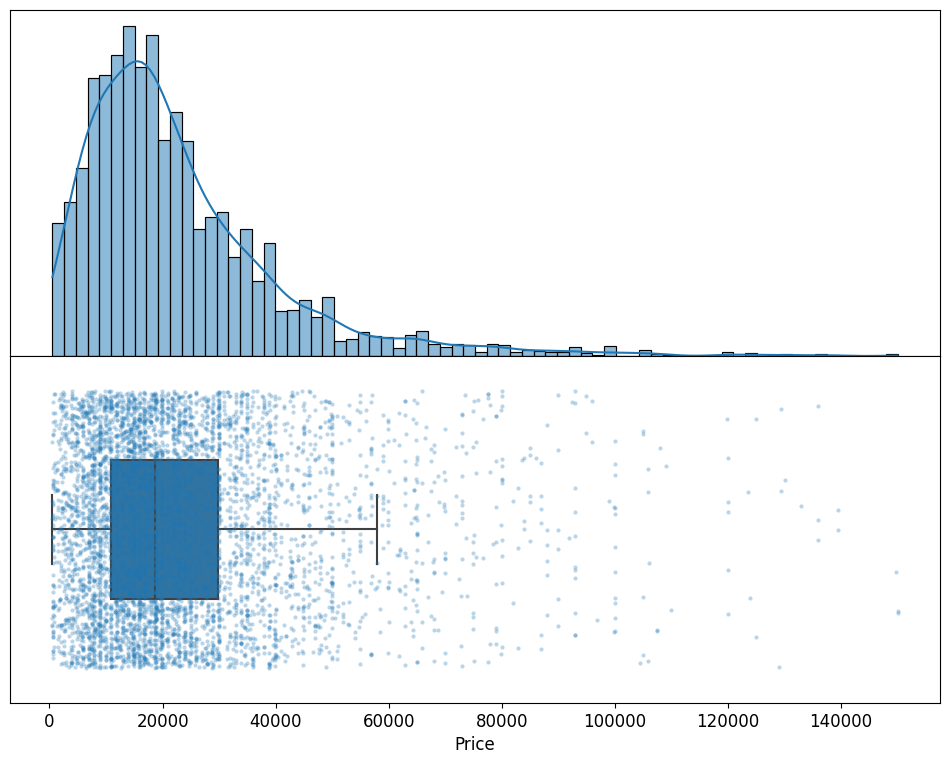

In [15]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"],
    orient='h',
    jitter=0.4,
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4,
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

This distribution makes much more sense.
Let's also look at the correlation between the Year the car was built and the Price.

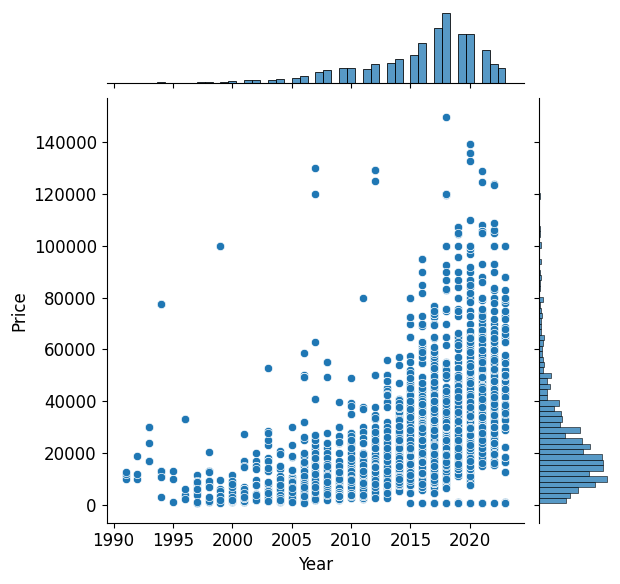

In [22]:
sns.jointplot(x='Year', y='Price', data=df)

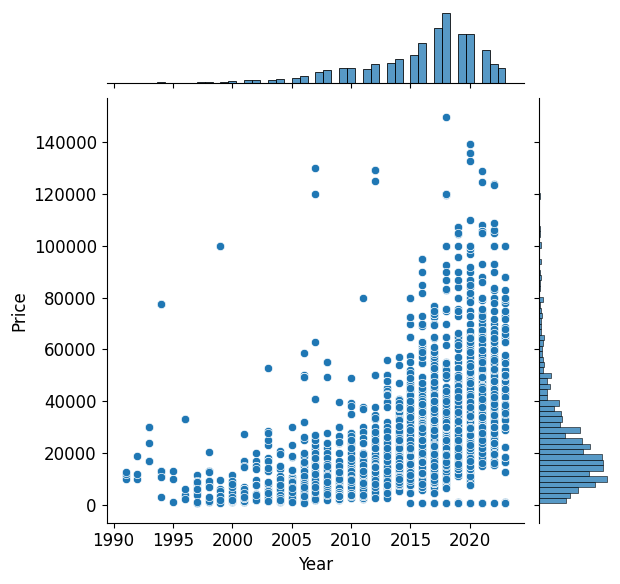

In [23]:
df = df[df.Year>1990]
sns.jointplot(x='Year', y='Price', data=df)

In this plot we can see that, from from 2005 to 2015, no cars are in the lowest price bracket. However, from 2015 to current, that bracket is populated again. Let's try removing all cars that are built from 2014 onwards, but are listed at a price lower than 1000 euros.

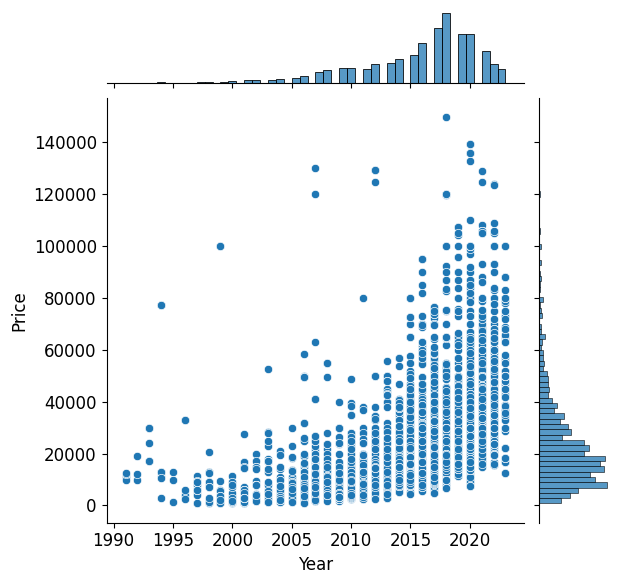

In [27]:
df = df[(df.Year<=2013) | (df.Price>=1000)]
sns.jointplot(x='Year', y='Price', data=df)